In [15]:
!pip install --upgrade pip
!pip install pymongo
!pip install wordcloud
!pip install pandas
!pip install matplotlib
!pip install -U nltk

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (19.0.3)
Requirement already up-to-date: nltk in /opt/conda/lib/python3.7/site-packages (3.4)


In [22]:
from pymongo import MongoClient
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='ds145639.mlab.com', port='45639', username='collector', password='collector123', no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find()

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    #if no_id:
    #    del df['_id']

    return df


In [4]:
people = read_mongo('landing_zone','people_data',query={})
posts = read_mongo('landing_zone','posts_data',query={})
full_data = people.append(posts)

full_data.head(5)

,_id,coordinates,data,geo,hashtags,id,lang,location,place,quoted,retweeted,texto,urls,user_mentions,usuario
0,5c6d9cf587963719cb193f84,None,Wed Feb 20 18:31:12 +0000 2019,None,[],1098288978099425281,pt,São Paulo,None,False,False,@sergioalberto40 @governosp Boa tarde @sergioa...,"[{'url': 'https://t.co/Ik1bkKwV3F', 'expanded_...","[{'screen_name': 'sergioalberto40', 'name': 'S...",DetranSP
1,5c6fc51c8796370b2cfc7fb2,None,Fri Feb 22 09:47:03 +0000 2019,None,[],1098881846094581760,pt,None,None,False,False,@CETSP_ @PMESP @prefsp @Estadao Não há nenhum ...,"[{'url': 'https://t.co/0kk8Vd9sUX', 'expanded_...","[{'screen_name': 'CETSP_', 'name': 'CET São Pa...",morumbi_will
2,5c702b228796370b2cfc7fca,None,Fri Feb 22 17:02:21 +0000 2019,None,[],1098991394960691200,pt,None,"{'id': '68e019afec7d0ba5', 'url': 'https://api...",False,False,"@PMESP Parabéns ao cão e ao seu guia, agora ma...","[{'url': 'https://t.co/B19oKpQtbg', 'expanded_...","[{'screen_name': 'PMESP', 'name': 'POLÍCIA MIL...",UlissysdeOlivei
3,5c703ae08796370b2cfc7ff3,None,Fri Feb 22 18:09:30 +0000 2019,None,[],1099008294545473536,pt,None,"{'id': 'd9d978b087a92583', 'url': 'https://api...",False,False,"@OficialBHTRANS vocês não respondem, mas vou i...","[{'url': 'https://t.co/Xyblvea0Hh', 'expanded_...","[{'screen_name': 'OficialBHTRANS', 'name': 'Of...",VictorVillafort
4,5c74434d8796370b2cfc8118,None,Mon Feb 25 19:34:32 +0000 2019,None,[],1100116855048626181,pt,"Penha, São Paulo","{'id': '68e019afec7d0ba5', 'url': 'https://api...",False,False,"@CETSP_ rua Canguaretama, altura do 45 solicit...","[{'url': 'https://t.co/3JzWP68MKd', 'expanded_...","[{'screen_name': 'CETSP_', 'name': 'CET São Pa...",Depdiego


In [5]:
import dateutil.parser

In [6]:
datetime_str = "Fri Feb 15 19:00:03 +0000 2019"  # Datestring in ISO 8601 format
some_datetime_obj = dateutil.parser.parse(datetime_str)

In [7]:
print(some_datetime_obj)

2019-02-15 19:00:03+00:00


In [16]:
def remove_urls(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text)

def to_lower(text):
    return text.lower()

format_date_time = lambda s: dateutil.parser.parse(datetime_str)
get_month = lambda d: d.month
get_day = lambda d: d.day

In [19]:
full_data['formatted_date'] = full_data['data'].apply(func=lambda string: dateutil.parser.parse(string))
full_data['mes'] = full_data['formatted_date'].apply(func=lambda date: date.month)
full_data['dia'] = full_data['formatted_date'].apply(func=lambda date: date.day)
full_data['ano'] = full_data['formatted_date'].apply(func=lambda date: date.year)
full_data['hora'] = full_data['formatted_date'].apply(func=lambda date: date.hour)
full_data['minuto'] = full_data['formatted_date'].apply(func=lambda date: date.minute)

full_data['texto_formatado'] = full_data['texto'].apply(lambda t: remove_urls(str(t)))
full_data['texto_formatado'] = full_data['texto_formatado'].apply(lambda t: to_lower(t))

In [20]:
tokenizer = TreebankWordTokenizer()
full_data['tokens'] = full_data['texto_formatado'].apply(lambda t: tokenizer.tokenize(t))
full_data[['texto_formatado','tokens']].head()

,texto_formatado,tokens
0,@sergioalberto40 @governosp boa tarde @sergioa...,"[@, sergioalberto40, @, governosp, boa, tarde,..."
1,@cetsp_ @pmesp @prefsp @estadao não há nenhum ...,"[@, cetsp_, @, pmesp, @, prefsp, @, estadao, n..."
2,"@pmesp parabéns ao cão e ao seu guia, agora ma...","[@, pmesp, parabéns, ao, cão, e, ao, seu, guia..."
3,"@oficialbhtrans vocês não respondem, mas vou i...","[@, oficialbhtrans, vocês, não, respondem, ,, ..."
4,"@cetsp_ rua canguaretama, altura do 45 solicit...","[@, cetsp_, rua, canguaretama, ,, altura, do, ..."


In [11]:
len(full_data)

70265

In [23]:
def create_stopword_list():
    portuguese_stops = set(stopwords.words('portuguese'))
    portuguese_stops.add('rt')

    with open('punctuation.txt','r+') as punct_file:
        puncts = punct_file.readlines()

    for item in puncts:    
        portuguese_stops.add(item.strip())
        
    return portuguese_stops

stop_w = create_stopword_list()

#aplica a remocao de stop-words
full_data['words'] = full_data['tokens'].apply(lambda w: [word for word in w if word not in stop_w]) 
#exibe resultado intermediario
full_data[['tokens','words']].head(10)

,tokens,words
0,"[@, sergioalberto40, @, governosp, boa, tarde,...","[sergioalberto40, governosp, boa, tarde, sergi..."
1,"[@, cetsp_, @, pmesp, @, prefsp, @, estadao, n...","[cetsp_, pmesp, prefsp, estadao, nenhum, ofici..."
2,"[@, pmesp, parabéns, ao, cão, e, ao, seu, guia...","[pmesp, parabéns, cão, guia, agora, nunca, ent..."
3,"[@, oficialbhtrans, vocês, não, respondem, ,, ...","[oficialbhtrans, respondem, vou, insistir., fl..."
4,"[@, cetsp_, rua, canguaretama, ,, altura, do, ...","[cetsp_, rua, canguaretama, altura, 45, solici..."
5,"[@, radiotransitofm, @, toffolettocatia, @, ra...","[radiotransitofm, toffolettocatia, radiobandne..."
6,"[@, cetsp_, parabens, a, @, cetsp_, pela, info...","[cetsp_, parabens, cetsp_, informacao, agil., ..."
7,"[⚽, embate, entre, @, corinthians, x, @, racin...","[⚽, embate, corinthians, x, racingclub, sudame..."
8,"[@, cetsp_, @, corinthians, @, racingclub, @, ...","[cetsp_, corinthians, racingclub, sudamericana..."
9,"[@, cetsp_, bom, dia, ,, mais, uma, vez, o, fa...","[cetsp_, bom, dia, vez, farol, problemas, loca..."


In [24]:
full_data['clean_text'] = full_data['words'].apply(lambda t: str(' '.join(t)))

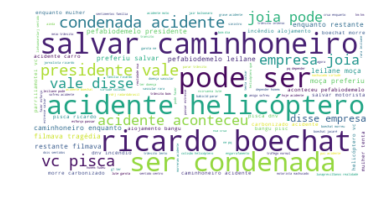

In [53]:
# Start with one review:
#text = 'processamento dos dados requer potentes plataformas de hardware, com alta escalabilidade e desempenho'
#text = " ".join(texto for texto in full_data.clean_text)
#print(text)

# Create and generate a word cloud image:
#wordcloud = WordCloud(background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figsize=[500,500]
#plt.figure(figsize=[10,10])
#plt.figure(figsize=[20,10])
#plt.show()

In [26]:
dias = full_data.groupby(['dia']).count()['_id']

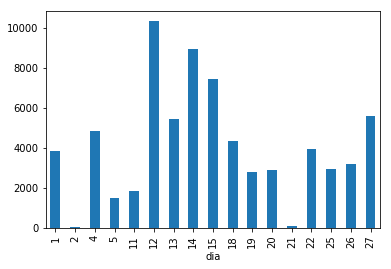

In [28]:
dias.plot(kind='bar')

In [56]:
file = open('words','w+')
file.write(text)

6254619